In [ ]:
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version 2.15.0


In [ ]:
image_size = 224
batch_size = 16
n_classes = 2
EPOCHS = 30

train_path = '/content/drive/MyDrive/Monkeypox Skin Image Dataset'

classes = {1 : "Monkeypox",
           2 : "Normal"
          }

In [ ]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if p_spatial > .75:
        image = tf.image.transpose(image)

    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º

    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)

    return image

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)
# set as training data

train_gen  = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = True,
    class_mode='categorical',
    subset='training')

# same directory as training data

valid_gen  = datagen.flow_from_directory(
    train_path ,
    target_size=(224, 224),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    class_mode='categorical',
    subset='validation')

Found 459 images belonging to 2 classes.
Found 113 images belonging to 2 classes.


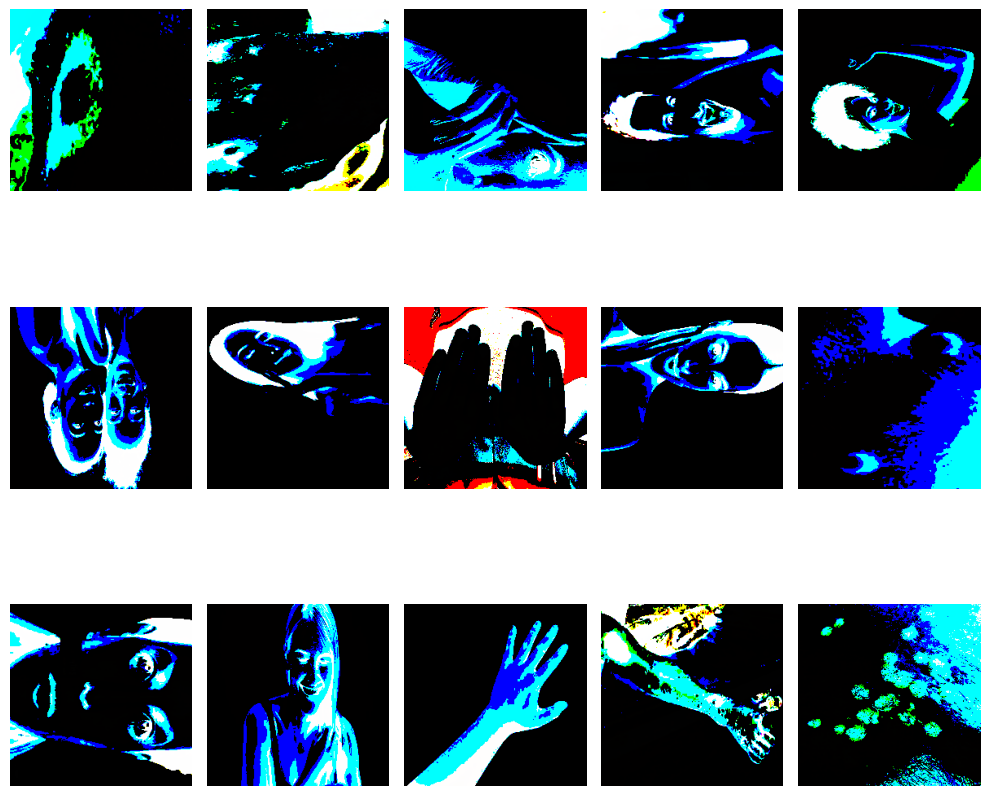

In [ ]:
warnings.filterwarnings("ignore")

images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(image_size, image_size, 3).astype("uint8"))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
!pip install vit_keras

In [ ]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

347502902/347502902 [==============================] - 4s 0us/step


In [ ]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


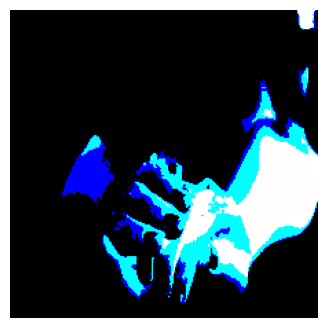

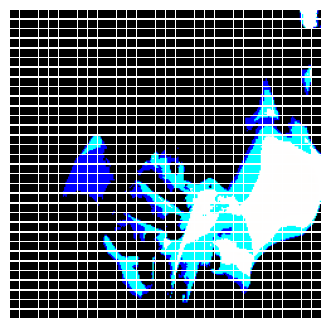

In [ ]:
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

x = train_gen.next()
image = x[0][0]

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)         

In [ ]:
warnings.filterwarnings("ignore")

learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size


EPOCHS = 5
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/5
28/28 [==============================] - 1431s 50s/step - loss: 0.8513 - accuracy: 0.4898 - val_loss: 0.7577 - val_accuracy: 0.4732
Epoch 2/5
28/28 [==============================] - 1248s 45s/step - loss: 0.5989 - accuracy: 0.7336 - val_loss: 0.5767 - val_accuracy: 0.7411
Epoch 3/5
28/28 [==============================] - 1302s 47s/step - loss: 0.4800 - accuracy: 0.8795 - val_loss: 0.5090 - val_accuracy: 0.8571
Epoch 4/5
28/28 [==============================] - 1288s 46s/step - loss: 0.4119 - accuracy: 0.9481 - val_loss: 0.4541 - val_accuracy: 0.9196
Epoch 5/5
20/28 [====================>.........] - ETA: 5:19 - loss: 0.3918 - accuracy: 0.9651

In [ ]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))